# 프로젝트 : 뉴스 요약봇 만들기
⭐️ Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.  
⭐️ 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다. 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.  
⭐️ Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.	두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.  

### ✏️ Import libraries & packages

In [1]:
# import data tools
import numpy as np
import pandas as pd


# import useful tools
import re     # regular expression
import os     # get system environment variables
import urllib.request    # url download

import warnings    # set warning indication
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


# import visual tools
import matplotlib.pyplot as plt
import seaborn as sns


# import natural language tools
from bs4 import BeautifulSoup        # handling html tags
from nltk.corpus import stopwords    # handling stopwords
import nltk
nltk.download('stopwords')

# import Tensorflow DL tools
import tensorflow    # abstractive summary
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from summa.summarizer import summarize    # extractive summary

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### ✏️ Define constants

In [2]:
# column index number
HEADLINES = 0
TEXT = 1

# max length of data for ML model
MAX_TEXT_LEN = 38
MAX_HEADLINES_LEN = 8

# minimum frequency of vocabularies to use in learning model for source & target data
SRC_MIN_FREQUENCY = 6
TAR_MIN_FREQUENCY = 3

# total size of vocabularies for source & target data
SRC_VOCAB_SIZE = 20000
TAR_VOCAB_SIZE = 13000

# integer encoding
PAD = 0
SOS = 1
EOS = 2

# learning model configurations
EMBEDDING_DIM = 128
HIDDEN_SIZE = 256

# early stopping patience
BATCH_SIZE = 256
EPOCHS = 50
ES_PATIENCE = 2

# length of print text divider ("=====")
DIVISOR_LENGTH = 70

### ✏️ Define useful methods

In [3]:
def print_divider(length = DIVISOR_LENGTH):
    print("=" * length)

### ✏️ Define NL data handling variables

In [4]:
# dictionary for English text normalization (length : 120)
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}


# English stopwords (length : 179)
stopwords_en = stopwords.words("english")

### ✏️ Define NL data pre-processing methods

In [5]:
# overall pre-processing on NL data
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower()                         # convert all characters into lowercases
    sentence = BeautifulSoup(sentence, "lxml").text     # remove all HTML tags
    sentence = re.sub(r'\([^)]*\)', '', sentence)       # remove all texts within parenthesis()
    sentence = re.sub('"','', sentence)                 # remove all quote symbol marks ("")
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
                                                        # text normalization acoording to constractions dictionary
    sentence = re.sub(r"'s\b","", sentence)             # cnovert all expressions with possesive words
    sentence = re.sub("[^a-zA-Z]", " ", sentence)       # remove all symbol marks including digits
    sentence = re.sub('[m]{2,}', 'mm', sentence)        # convert continuous "m"s more than 3
    
    
    ### remove_stopwords : option to decide whether remove stopwords or not
    # split sentnece into list of words -> remove stopwords & 1-character-long words -> concatenate as one string
    if remove_stopwords:
        result = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    # keep stopwords -> remove 1-character-long words -> concatenate as one string
    else:
        result = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    
    return result

---

### ✏️ Load dataset

In [6]:
# news articls dataset url
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

# download dataset from url
data = pd.read_csv("news_summary_more.csv", encoding = "iso-8859-1")

# analysis of dataset
print(data.shape)         # total 98401 samples with 2 columns
print(data.columns)       # total 2 columns : "text" as main content, "headlines" as its summary 
print_divider()
print(data.sample(10))    # pick random 10 samples

(98401, 2)
Index(['headlines', 'text'], dtype='object')
                                               headlines  \
90716  Police complaint against Snapdeal for non-paym...   
95373  Ex-Delhi Minister AK Walia quits Congress befo...   
31563  Cricketer beats 60 lakh people to win fantasy ...   
61694  My body had two major transformations in over ...   
18210  Kerala nuns protest demanding arrest of rape a...   
23830  64-yr-old sets record by swimming 3 km with ha...   
61199  Andhra Pradesh hosts its first Hot Air Balloon...   
14565  US Navy veteran charged for mailing toxic lett...   
37322  No action taken by Pakistan to get Taliban to ...   
92851  Advani, Uma to face conspiracy charges in Babr...   

                                                    text  
90716  Bengaluru-based apparel seller Rajdhani Cotton...  
95373  AK Walia, who was Health Minister in former De...  
31563  England's second-highest Test wicket-taker Stu...  
61694  Actress Bhumi Pednekar has said that in 

### ✏️ Pre-process on dataset 1 : remove duplicated & null values

1. Remove **duplicated** data

In [7]:
# count unique values in each column
original_sample_cnt = len(data)
print(">>> Total samples                                   : ", original_sample_cnt)
print(">>> The number of unique values in TEXT column      : ", data["text"].nunique())
print(">>> The number of unique values in HEADLINES column : ", data["headlines"].nunique())

print_divider()

# remove duplicated data in TEXT columns
# keep duplicated in HEADLINES columns, because it might include use commonly frequent words
data.drop_duplicates(subset = ["text"], inplace=True)
unique_sample_cnt = len(data)
print(">>> Total", original_sample_cnt - unique_sample_cnt, "duplicated sample data removed.")
print(">>> Total samples                                   : ", unique_sample_cnt)

>>> Total samples                                   :  98401
>>> The number of unique values in TEXT column      :  98360
>>> The number of unique values in HEADLINES column :  98280
>>> Total 41 duplicated sample data removed.
>>> Total samples                                   :  98360


2. Remove **NULL** data

In [8]:
# count empty values in each column
print(data.isnull().sum())

print_divider()

# remove data including empty values
data.dropna(axis=0, inplace=True)
filled_sample_cnt = len(data)
print(">>> Total", unique_sample_cnt - filled_sample_cnt, "empty sample data removed.")
print(">>> Total samples : ", filled_sample_cnt)

headlines    0
text         0
dtype: int64
>>> Total 0 empty sample data removed.
>>> Total samples :  98360


### ✏️ Pre-process on dataset 2 : Overall NL pre-process
   - Convert into lower cases  
   - Remove HTML tags, texts within parenthesis, symbolic characters, possesive expressions
   - Convert expressions with contractions, pssesive words, and continuous "m"s ("Hmmmmm" -> "Hmm")

1. Pre-process on data in **TEXT** column

In [9]:
# pre-process on data in TEXT column (including removing stopwords)

# save original data as example to check the operation of pre-processing method
original_text = data["text"][0]

# indicate processing state
print("Pre-processing on data in TEXT column...")
print("Wait...")

# perform pre-process on data in TEXT column
data["text"] = data["text"].apply(lambda x: preprocess_sentence(x, remove_stopwords = True))

# save pre-processed data as example to check the operation of pro-processing method
preprocessed_text = data["text"][0]

# print pre-processing result
print_divider()
print(">>> Original data example      : ", original_text)
print(">>> Pre-processed data example : ", preprocessed_text)
print_divider()
print(">>> Pre-processing on data in TEXT column of ", len(data), " samples successfly finished!")

Pre-processing on data in TEXT column...
Wait...
>>> Original data example      :  Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
>>> Pre-processed data example :  saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
>>> Pre-processing on data in TEXT column of  98360  samples successfly finished!


2. Pre-process on data in **HEADLINES** column

In [10]:
# pre-process on data in HEADLINES column (including removing stopwords)

# save original data as example to check the operation of pre-processing method
original_headline = data["headlines"][0]

# indicate processing state
print("Pre-processing on data in HEADLINES column...")
print("Wait...")

# perform pre-process on data in HEADLINES column
data["headlines"] = data["headlines"].apply(lambda x: preprocess_sentence(x, remove_stopwords = False))

# save pre-processed data as example to check the operation of pro-processing method
preprocessed_headline = data["headlines"][0]

# print pre-processing result
print_divider()
print(">>> Original data example      : ", original_headline)
print(">>> Pre-processed data example : ", preprocessed_headline)
print_divider()
print(">>> Pre-processing on data in HEADLINES column of ", len(data), " samples successfly finished!")

Pre-processing on data in HEADLINES column...
Wait...
>>> Original data example      :  upGrad learner switches to career in ML & Al with 90% salary hike
>>> Pre-processed data example :  upgrad learner switches to career in ml al with salary hike
>>> Pre-processing on data in HEADLINES column of  98360  samples successfly finished!


3. Remove **NULL** data resulted by pre-processing

In [11]:
# count pre-processed samples
preprocessed_sample_cnt = len(data)

# convert empty values as NaN
data.replace("", np.nan, inplace = True)

# count empty(NaN) values in each column
data.isnull().sum()

# remove data including empty(NaN) values
data.dropna(axis=0, inplace=True)
filled_sample_cnt = len(data)
print(">>> Total", preprocessed_sample_cnt - filled_sample_cnt, "empty pre-processed sample data removed.")
print(">>> Total samples : ", filled_sample_cnt)

>>> Total 0 empty pre-processed sample data removed.
>>> Total samples :  98360


### ✏️ Pre-process on dataset 3 : filter over-length data

1. Analyze the length of data in **TEXT** column & set *MAX_TEXT_LEN*

Minimum length of string data in TEXT column      : 1
Maximum length of string data in TEXT column      : 60
Average length of string data in TEXT column      : 35.09968483123221


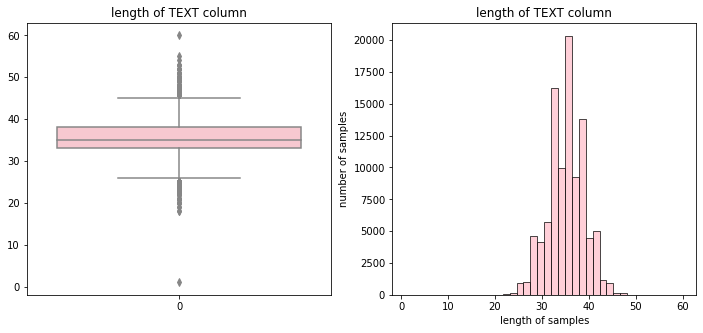

In [12]:
# analyze length of string data in TEXT column
text_len = [len(s.split()) for s in data["text"]]
print("Minimum length of string data in TEXT column      : {}".format(np.min(text_len)))
print("Maximum length of string data in TEXT column      : {}".format(np.max(text_len)))
print("Average length of string data in TEXT column      : {}".format(np.mean(text_len)))


# visualize the TEXT column length analysis result
text_fig = plt.figure(figsize = (12, 5))

text_subplot1 = text_fig.add_subplot(1, 2, 1)
sns.boxplot(data = text_len, color = "pink")
text_subplot1.set_title("length of TEXT column")

text_subplot2 = text_fig.add_subplot(1, 2, 2)
sns.histplot(data = text_len, bins = 40, color = "pink")
text_subplot2.set_title("length of TEXT column")
text_subplot2.set_xlabel('length of samples')
text_subplot2.set_ylabel('number of samples')

plt.show()

- 기사 본문("text" column)의 길이(단어 갯수) 분석 결과, 최대 38 단어 길이의 데이터만 활용하여도 적합하다고 판단
- 상단의 상수 정의 부분 코드에서 *MAX_TEXT_LEN = 38* 로 설정

2. Analyze the length of data in **HEADLINES** column & set *MAX_HEADLINES_LEN*

Minimum length of string data in HEADLINES column : 1
Maximum length of string data in HEADLINES column : 16
Average length of string data in HEADLINES column : 9.299532330215534


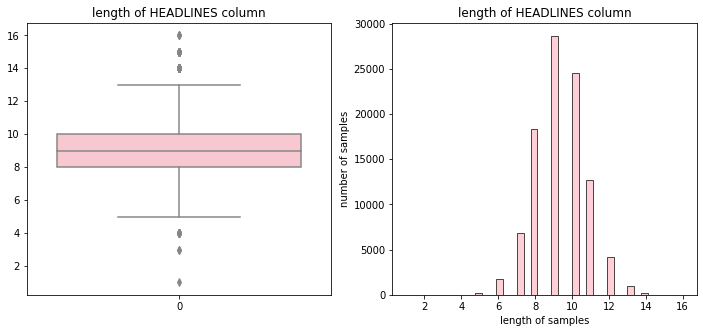

In [13]:
# analyze length of string data in HEADLINES column
headlines_len = [len(s.split()) for s in data["headlines"]]
print("Minimum length of string data in HEADLINES column : {}".format(np.min(headlines_len)))
print("Maximum length of string data in HEADLINES column : {}".format(np.max(headlines_len)))
print("Average length of string data in HEADLINES column : {}".format(np.mean(headlines_len)))



# visualize the TEXT column length analysis result
headlines_fig = plt.figure(figsize = (12, 5))

headlines_subplot1 = headlines_fig.add_subplot(1, 2, 1)
sns.boxplot(data = headlines_len, color = "pink")
headlines_subplot1.set_title("length of HEADLINES column")

headlines_subplot2 = headlines_fig.add_subplot(1, 2, 2)
sns.histplot(data = headlines_len, bins = 40, color = "pink")
headlines_subplot2.set_title("length of HEADLINES column")
headlines_subplot2.set_xlabel('length of samples')
headlines_subplot2.set_ylabel('number of samples')

plt.show()

- 기사 본문("headlines" column)의 길이(단어 갯수) 분석 결과, 최대 8 단어 길이의 데이터만 활용하여도 적합하다고 판단
- 상단의 상수 정의 부분 코드에서 *MAX_HEADLINES_LEN = 8* 으로 설정

3. Verify proper values of *MAX_TEXT_LEN* and *MAX_HEADLINES_LEN*

In [14]:
# define method to count over-length samples throughout total samples
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print(">>> Percentage of samples which length is under %s : %s"%(max_len, (cnt / len(nested_list))))

In [15]:
# check TEXT data which length is under 38 to verify MAX_TEXT_LEN value is proper or not
print("Checking data length in TEXT column...")
below_threshold_len(MAX_TEXT_LEN, data["text"])

print_divider()

# check HEADLINES data which length is under 8 to verify MAX_HEADLINES_LEN value is proper or not)
print("Checking data length in HEADLINES column...")
below_threshold_len(MAX_HEADLINES_LEN,  data["headlines"])

Checking data length in TEXT column...
>>> Percentage of samples which length is under 38 : 0.8163379422529483
Checking data length in HEADLINES column...
>>> Percentage of samples which length is under 8 : 0.2755693371289142


- "text" 내용의 길이가 MAX_TEXT_LEN = 38 이하인 데이터가 약 81.6% 이므로 적절한 값으로 판단!
- "headlines" 내용의 길이가 MAX_HEADLINES_LEN =8 이하인 데이터가 약 89.3% 이므로 적잘한 값으로 판단!

4. Filter over-length data (exclude samples with over-length data)

In [16]:
# count pre-processed samples
total_sample_cnt = len(data)

# exclude over-length sampels
data = data[data["text"].apply(lambda x: len(x.split()) <= MAX_TEXT_LEN)]
data = data[data["headlines"].apply(lambda x: len(x.split()) <= MAX_HEADLINES_LEN)]
short_sample_cnt = len(data)
print(">>> Total", total_sample_cnt - short_sample_cnt, "over-length sample data removed.")
print(">>> Total samples : ", short_sample_cnt)

>>> Total 76156 over-length sample data removed.
>>> Total samples :  22204


### ✏️ Pre-processing 4 : Add **"SOS"** and **"EOS"** tokens

1. Generate two new columns to mark each of SOS and EOS tokens

In [17]:
# create new column to add SOS (start of sentence) token in front of "headlines" data
data["decoder_input"] = data["headlines"].apply(lambda x : "sostoken " + x)

# create new column to add EOS (end of sentence) token in the end of "headlines" data
data["decoder_target"] = data["headlines"].apply(lambda x : x + " eostoken")


# print results
print("New columns generated : decoder_input, decoder_target")
print_divider()
print(data.shape)         # total 72997 samples with 4 columns
print(data.columns)       # total 4 columns : "text", "headlines", "decoder_input", "decoder_target"
print_divider()
print(data.sample(10))    # pick random 10 samples

New columns generated : decoder_input, decoder_target
(22204, 4)
Index(['headlines', 'text', 'decoder_input', 'decoder_target'], dtype='object')
                                               headlines  \
23603  samsung quarterly revenue dips amid slow smart...   
59104          formula one unveils new fan inspired logo   
60692  un urges myanmar to give citizenship to rohingyas   
4701   no politician can match vajpayee popularity ni...   
83373  terrorists explained terrorism to the world pm...   
18894  duterte calls hitler insane at israel holocaus...   
93332  charged with terrorism over pakistani student ...   
25996  poisonous snakes found in maharashtra school k...   
41320  militants gunned down in two encounters in kas...   
82059       around people lose to atm fraud in bengaluru   

                                                    text  \
23603  samsung electronics posted revenue billion apr...   
59104  formula one unveiled new logo season ending ra...   
60692  un huma

2. Assign each column to input variables to use in DL model

In [18]:
encoder_input = np.array(data["text"])            # input of encoder
decoder_input = np.array(data["decoder_input"])   # input of decoder
decoder_target = np.array(data["decoder_target"]) # label of decoder

### ✏️ Pre-processing 5 : split training & validation & test data

1. Shuffle indices of datasets

In [19]:
# shuffle indices order
indices = np.arange(encoder_input.shape[0])    # generate array with indices of datasets
np.random.shuffle(indices)                     # shuffle the indices order


# assign shuffled data to input variables of DL model
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

2. Split datasets into training data & test data

In [20]:
# set split ratio
n_of_val = int(len(encoder_input)*0.2)


# split encoder input data
encoder_input_train = encoder_input[:-n_of_val]
encoder_input_test = encoder_input[-n_of_val:]

# split decoder input data
decoder_input_train = decoder_input[:-n_of_val]
decoder_input_test = decoder_input[-n_of_val:]

# split decoder target data
decoder_target_train = decoder_target[:-n_of_val]
decoder_target_test = decoder_target[-n_of_val:]


print("Dataset split is finished!")
print(">>> The number of training data samples : ", len(encoder_input_train))
print(">>> The number of teset data samples    : ", len(encoder_input_test))

Dataset split is finished!
>>> The number of training data samples :  17764
>>> The number of teset data samples    :  4440


### ✏️ Pre-process on dataset 6 : encoding (word <-> index coverting)

1. Analysis the usage of vocabularies and their frequency in **TEXT**(source) data

In [21]:
# generate tokenizer for source data ("text" column data)
src_tokenizer = Tokenizer()

# generate vocabulary collection from source data
src_tokenizer.fit_on_texts(encoder_input_train)

In [22]:
# count how many kinds of vocabularies used & how often used
# count total words & how much rare vocabulary used
total_cnt = len(src_tokenizer.word_index)    # how many kinds of vocabularies
rare_cnt = 0                                 # vocabularies barely used (less than SRC_MIN_FREQUENCY)
total_freq = 0                               # total words
rare_freq = 0                                # total rare words (used less than SRC_MIN_FREQUENCY)

for key, value in src_tokenizer.word_counts.items():
    # key = vocabulary, value = frequency (how many times used)
    
    total_freq = total_freq + value

    # count barely used vocabularies (less than SRC_MIN_FREQUENCY)
    if(value < SRC_MIN_FREQUENCY):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

        
        
# print analysis result
print(">>> Total size(count) of vocabularies from TEXT column       : ", total_cnt)
print(">>> Total count of rare vocabularies used less than %s times  :  %s"%(SRC_MIN_FREQUENCY, rare_cnt))
print(">>> Total size(count) of frequently used vocabularies        :  %s"%(total_cnt - rare_cnt))
print(">>> Percentage of rare vocabularies throughout whole ones    : ", (rare_cnt / total_cnt) * 100)
print(">>> Frequency of rare vocabularies use din whole TEXT data   : ", (rare_freq / total_freq) * 100)

>>> Total size(count) of vocabularies from TEXT column       :  37755
>>> Total count of rare vocabularies used less than 6 times  :  26476
>>> Total size(count) of frequently used vocabularies        :  11279
>>> Percentage of rare vocabularies throughout whole ones    :  70.12581115084095
>>> Frequency of rare vocabularies use din whole TEXT data   :  8.280811771923146


- "text" column 데이터에서 6번 이상 사용된 단어들만 학습에 사용할 경우,  
  총 20268가지의 단어를 사용하게 되며 데이터의 약 3.68%를 차지하는 단어들이 배제될 것이다.   
  3.68%의 비율은 학습 데이터에서 배제되어도 충분히 적은 양이므로, "6번 이상" 사용된 단어들을 기준으로 학습을 진행하도록 한다.
- 6번 이상 사용된 단어들은 20268가지가 있으므로, 인코딩할 단어의 가짓수는 *SRC_VOCAB_SIZE = 20000* 으로 설정하도록 한다.

2. Set vocabulary size and generate word <-> index dictionary for **TEXT**(source) data  
   Convert string data into interger-encoded data

In [23]:
# re-generate tokenizer for source data ("text" column data)
# total number of vocabularies are limited as SRC_VOCAB_SIZE = 20000
src_tokenizer = Tokenizer(num_words = SRC_VOCAB_SIZE)

# generate vocabulary collection from source data
src_tokenizer.fit_on_texts(encoder_input_train)

# convert string data in "text" columns into interger-encoded data
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)


print("Integer-encoding for source text data is finished!")
print("Integer-encoding example : ", encoder_input_train[0])

Integer-encoding for source text data is finished!
Integer-encoding example :  [321, 103, 23, 667, 41, 222, 11280, 17716, 5532, 6008, 248, 5752, 27, 8, 390, 705, 17717, 587, 90, 364, 152, 514, 125, 955, 152, 706, 955, 152, 417, 432, 8, 367, 99, 4742, 166]


3. Analysis the usage of vocabularies and their frequency in **HEADLINES**(target) data

In [24]:
# generate tokenizer for source data ("headlines" column data)
tar_tokenizer = Tokenizer()

# generate vocabulary collection from source data
tar_tokenizer.fit_on_texts(decoder_input_train)

In [25]:
# count how many kinds of vocabularies used & how often used
# count total words & how much rare vocabulary used
total_cnt = len(tar_tokenizer.word_index)    # how many kinds of vocabularies
rare_cnt = 0                                 # vocabularies barely used (less than TAR_MIN_FREQUENCY)
total_freq = 0                               # total words
rare_freq = 0                                # total rare words (used less than TAR_MIN_FREQUENCY)

for key, value in tar_tokenizer.word_counts.items():
    # key = vocabulary, value = frequency (how many times used)
    
    total_freq = total_freq + value

    # count barely used vocabularies (less than TAR_MIN_FREQUENCY)
    if(value < TAR_MIN_FREQUENCY):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

        
        
# print analysis result
print(">>> Total size(count) of vocabularies from TEXT column       : ", total_cnt)
print(">>> Total count of rare vocabularies used less than %s times  :  %s"%(TAR_MIN_FREQUENCY, rare_cnt))
print(">>> Total size(count) of frequently used vocabularies        :  %s"%(total_cnt - rare_cnt))
print(">>> Percentage of rare vocabularies throughout whole ones    : ", (rare_cnt / total_cnt) * 100)
print(">>> Frequency of rare vocabularies use din whole TEXT data   : ", (rare_freq / total_freq) * 100)

>>> Total size(count) of vocabularies from TEXT column       :  17092
>>> Total count of rare vocabularies used less than 3 times  :  10078
>>> Total size(count) of frequently used vocabularies        :  7014
>>> Percentage of rare vocabularies throughout whole ones    :  58.9632576644044
>>> Frequency of rare vocabularies use din whole TEXT data   :  8.323452536144066


- "headlines" columns 데이터에서 3번 이상 사용된 단어들만 학습에 사용할 경우,  
  총 13221가지의 단어를 사용하게 되며 데이터의 약 3.60%를 차지하는 단어들이 배제될 것이다.   
  3.60%의 비율은 학습 데이터에서 배제되어도 충분히 적은 양이므로, "3번 이상" 사용된 단어들을 기준으로 학습을 진행하도록 한다.
- 3번 이상 사용된 단어들은 13221가지가 있으므로, 인코딩할 단어의 가짓수는 *TAR_VOCAB_SIZE = 13000* 으로 설정하도록 한다.

4. Set vocabulary size and generate word <-> index dictionary for **HEADLINES**(target) data  
   Convert string data into interger-encoded data

In [26]:
# re-generate tokenizer for source data ("headlines" column data)
# total number of vocabularies are limited as TAR_VOCAB_SIZE = 13000
tar_tokenizer = Tokenizer(num_words = TAR_VOCAB_SIZE)

# generate vocabulary collection from source data
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# convert string data in "headlines" columns into interger-encoded data
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)


print("Integer-encoding for target text data is finished!")
print("Integer-encoding example 1 : ", decoder_input_train[0])
print("Integer-encoding example 1 : ", decoder_target_train[0])

Integer-encoding for target text data is finished!
Integer-encoding example 1 :  [1, 355, 60, 507, 259, 11, 9644, 3155]
Integer-encoding example 1 :  [355, 60, 507, 259, 11, 9644, 3155, 2]


5. Remove data including only barely used words

In [27]:
# collect indices of samples which data including only barely used words (not interger-encoded)
# the length of interger-encoded result might be 1 because of SOS or EOS remains
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]



# remove samples by indices which training data include only barely used words
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

print(">>> Total", len(drop_train), "sample data with rare words removed from training data.")
print(">>> Total samples of training data : ", len(encoder_input_train))
print_divider()



# remove samples by indices which test data include only barely used words
encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print(">>> Total", len(drop_train), "sample data with rare words removed from test data.")
print(">>> Total samples of test data     : ", len(encoder_input_test))

>>> Total 0 sample data with rare words removed from training data.
>>> Total samples of training data :  17764
>>> Total 0 sample data with rare words removed from test data.
>>> Total samples of test data     :  4439


### ✏️ Pre-process on dataset 7 : padding (unify data length)

In [28]:
# padding training data
encoder_input_train = pad_sequences(encoder_input_train, maxlen = MAX_TEXT_LEN, padding = "post")
decoder_input_train = pad_sequences(decoder_input_train, maxlen = MAX_HEADLINES_LEN, padding = "post")
decoder_target_train = pad_sequences(decoder_target_train, maxlen = MAX_HEADLINES_LEN, padding = "post")


# padding test data
encoder_input_test = pad_sequences(encoder_input_test, maxlen = MAX_TEXT_LEN, padding = "post")
decoder_input_test = pad_sequences(decoder_input_test, maxlen = MAX_HEADLINES_LEN, padding = "post")
decoder_target_test = pad_sequences(decoder_target_test, maxlen = MAX_HEADLINES_LEN, padding = "post")


print("Padding of interger-encoded data is finished!")
print("Integer-encoding example : ")
for i in range(5):
    print("\t", decoder_input_train[i])

Padding of interger-encoded data is finished!
Integer-encoding example : 
	 [   1  355   60  507  259   11 9644 3155]
	 [3535 2543  489  490 2135 1127 1970 3156]
	 [7016 1066    3  195 2136 4055 1250  177]
	 [   1  130    6 1399  683   83 3157   53]
	 [2544   30 3536    5 2545 1067  461   34]


---

### ✏️ Build seq2seq learning model with attention mechanism for training

1. Define layer structure **ENCODER** structure

In [29]:
# set ENCODER input shape
encoder_inputs = Input(shape = (MAX_TEXT_LEN,))

# define embedding layer of ENCODER
enc_emb = Embedding(SRC_VOCAB_SIZE, EMBEDDING_DIM)(encoder_inputs)

# LSTM layer 1 of ENCODER
encoder_lstm1 = LSTM(HIDDEN_SIZE, return_sequences = True, return_state = True, dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM layer 2 of ENCODER
encoder_lstm2 = LSTM(HIDDEN_SIZE, return_sequences = True, return_state = True, dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM layer 3 of ENCODER
encoder_lstm3 = LSTM(HIDDEN_SIZE, return_sequences = True, return_state = True, dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

2. Define layer structure **DECODER** with attention mechanism

In [30]:
# set DECODER input shape
decoder_inputs = Input(shape=(None,))

# define embedding layer of DECODER
dec_emb_layer = Embedding(TAR_VOCAB_SIZE, EMBEDDING_DIM)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM layer of DECODER
decoder_lstm = LSTM(HIDDEN_SIZE, return_sequences = True, return_state = True, dropout = 0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [31]:
# 디코더의 출력층
#decoder_softmax_layer = Dense(TAR_VOCAB_SIZE, activation = "softmax")
#decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
#model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
#model.summary()

In [32]:
# define attention layer of DECODER
attn_layer = AdditiveAttention(name = "attention_layer")
attn_out = attn_layer([decoder_outputs, encoder_output3])    # transfer all hidden states at every time step and get results

# connect resulting values of the attention layer and hidden states values of DECODER
decoder_concat_input = Concatenate(axis = -1, name = "concat_layer")([decoder_outputs, attn_out])

# define output layer of DECODER
decoder_softmax_layer = Dense(TAR_VOCAB_SIZE, activation = "softmax")
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

3. Build seq2seq learning model

In [33]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
print("My seq2seq model with attention mechanism for training successfully built!")
print(model.summary())

My seq2seq model with attention mechanism for training successfully built!
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
___________________

### ✏️ Perform training with seq2seq model

1. Perform training with seq2seq model

In [34]:
model.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy")
es = EarlyStopping(monitor = "val_loss", patience = ES_PATIENCE, verbose = 1)
history = model.fit(x = [encoder_input_train, decoder_input_train], \
                    y = decoder_target_train, \
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test), \
                    batch_size = BATCH_SIZE,
                    callbacks = [es],
                    epochs = EPOCHS)

print(">>> Model training is sucessfully finished!")

Epoch 1/50
70/70 [==============================] - 13s 92ms/step - loss: 7.2815 - val_loss: 6.7234
Epoch 2/50
70/70 [==============================] - 5s 75ms/step - loss: 6.8256 - val_loss: 6.4786
Epoch 3/50
70/70 [==============================] - 5s 75ms/step - loss: 6.5779 - val_loss: 6.3571
Epoch 4/50
70/70 [==============================] - 5s 76ms/step - loss: 6.4187 - val_loss: 6.2238
Epoch 5/50
70/70 [==============================] - 5s 77ms/step - loss: 6.2675 - val_loss: 6.1349
Epoch 6/50
70/70 [==============================] - 5s 77ms/step - loss: 6.1192 - val_loss: 6.0696
Epoch 7/50
70/70 [==============================] - 5s 77ms/step - loss: 5.9703 - val_loss: 5.9964
Epoch 8/50
70/70 [==============================] - 5s 78ms/step - loss: 5.8136 - val_loss: 5.9324
Epoch 9/50
70/70 [==============================] - 5s 78ms/step - loss: 5.6638 - val_loss: 5.8626
Epoch 10/50
70/70 [==============================] - 5s 78ms/step - loss: 5.4999 - val_loss: 5.8057
Epoch 11

2. Visualize training process

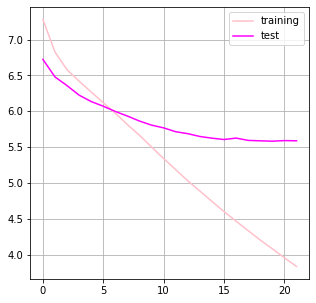

>>> Minimum loss during training   :  3.8343582153320312
>>> Final loss during training     :  3.8343582153320312
>>> Minimum loss during validation :  5.581840515136719
>>> Final loss during valication   :  5.587233543395996


In [35]:
training_loss_fig = plt.figure(figsize = (5, 5))

plt.plot(history.history["loss"], label = "training", color = "pink")
plt.plot(history.history["val_loss"], label = "test", color = "magenta")

plt.legend()
plt.grid()

plt.show()

print(">>> Minimum loss during training   : ", min(history.history["loss"]))
print(">>> Final loss during training     : ", history.history["loss"][-1])
print(">>> Minimum loss during validation : ", min(history.history["val_loss"]))
print(">>> Final loss during valication   : ", history.history["val_loss"][-1])

### ✏️ Implement inference model

1. Get dictionary of string word <-> integer encoding indcides

In [36]:
# dictionary of (integer -> word) from source data ("text" column)
src_index_to_word = src_tokenizer.index_word

# dictionary of (word -> integer) from target data ("headlines" column)
tar_word_to_index = tar_tokenizer.word_index

# dictionary of (integer -> word) from target data ("headlines" column)
tar_index_to_word = tar_tokenizer.index_word

2. Build seq2seq model with attention mechanism for inference (different from training model)

In [37]:
# define ENCODER model
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_output3, state_h3, state_c3])

# create tensors(matrices) to save states at previous steps
decoder_state_input_h = Input(shape=(HIDDEN_SIZE,))
decoder_state_input_c = Input(shape=(HIDDEN_SIZE,))

# define embedding layer of DECODER
dec_emb2 = dec_emb_layer(decoder_inputs)

# define LSTM layer of DECODER
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])
    # 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
    # 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.

# define attention methods
decoder_hidden_state_input = Input(shape = (MAX_TEXT_LEN, HIDDEN_SIZE))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# define output layer of DECODER
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# build final DECODER model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print("My seq2seq model with attention mechanism for inference successfully built!")
print(decoder_model.summary())

My seq2seq model with attention mechanism for inference successfully built!
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1664000     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
________________

3. Define inference method

In [38]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)    # get encoder information from input_seq
    
    # generate tokens of "SOS" (start of sentence)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index["sostoken"]

    
    # start generating sentences
    stop_condition = False
    decoded_sentence = ""
    
    while not stop_condition:    # loop until stop_condition becomes True
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        # if it is not EOS, keep generating sentences
        if (sampled_token != "eostoken"):
            decoded_sentence += " " + sampled_token

        # if it is EOS or over MAX_HEADLINES_LEN, stop generating sentences -> stop_condition becomes True
        if (sampled_token == "eostoken"  or len(decoded_sentence.split()) >= (MAX_HEADLINES_LEN - 1)):
            stop_condition = True

        # updates target sequences with length 1
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # update state information
        e_h, e_c = h, c

    return decoded_sentence

### ✏️ Experiments of "abstractive summarization" with attention mechanism

1. Define methods to convert(decode) interger-encoded results into text strings

In [39]:
# define methods to decode source data ("text" column)
def seq2text(input_seq):
    result = ""
    for i in input_seq:
        if (i != PAD):
            result = result + src_index_to_word[i] + " "
    return result


# define method to decode target data ("headlines" column)
def seq2summary(input_seq):
    result = ""
    for i in input_seq:
        if (i == EOS):    # stop decoding
            break
        if (i != PAD and i != SOS):    # keep decoding
            result = result + tar_index_to_word[i] + " "
    return result

2. Compare expected (label) and experimental results summary

In [40]:
for i in range(50, 100):
    print(">>> Original article sources      :", seq2text(encoder_input_test[i]))
    print(">>> Actual(label) headline        :", seq2summary(decoder_input_test[i]))
    print(">>> Suggested(inference) headline :", decode_sequence(encoder_input_test[i].reshape(1, MAX_TEXT_LEN)))
    print("\n")

>>> Original article sources      : pakistan foreign office spokesperson mohammad faisal saturday tweeted visa applications former indian navy officer kulbhushan jadhav wife mother received processed jadhav first meeting family since arrest march pakistan reportedly rejected india plea consular access jadhav times 
>>> Actual(label) headline        : visas for jadhav wife mother being processed pakistan 
>>> Suggested(inference) headline :  pakistan pakistan pakistan jadhav pakistan pak pak


>>> Original article sources      : environmental group activists crashed shaped drone french nuclear plant spent fuel pool building highlight security highlights vulnerability buildings contain highest amount said called convert spent fuel buildings bunkers greater safety 
>>> Actual(label) headline        : activists crash drone into french nuclear plant 
>>> Suggested(inference) headline :  video of million stolen in years


>>> Original article sources      : university california moved federa

>>> Suggested(inference) headline :  spacex launches rocket of electric rocket rocket


>>> Original article sources      : google announced doodle google contest india inviting students make doodle company logo winner would win lakh college scholarship doodle would featured company website children day contest open students class doodle theme inspires 
>>> Actual(label) headline        : google announces lakh doodle google contest in india 
>>> Suggested(inference) headline :  india to host its first service


>>> Original article sources      : abhishek bachchan instagram account hacked turkish cyber group tim one posts tagged katrina kaif wrote love another post featured missile picture caption read operation support turkey earlier abhishek twitter account also hacked group 
>>> Actual(label) headline        : abhishek bachchan instagram account gets hacked 
>>> Suggested(inference) headline :  kohli reacts to become sachin tendulkar


>>> Original article sources      : year old mu

>>> Suggested(inference) headline :  women were metoo on entering time


>>> Original article sources      : addressing nation mann ki baat programme pm narendra modi announced creation sports talent search portal india aspiring sportspersons portal sportspersons register get help ministry sports getting proper training athletes required upload videos portal showcasing excellence sport 
>>> Actual(label) headline        : pm announces talent search portal for sportspersons 
>>> Suggested(inference) headline :  trump appointed india of india pm modi


>>> Original article sources      : indian cricket team played first odi years ago july played odis cricket history india played odis till date winning success rate india first odi overs side game england former lost four wickets 
>>> Actual(label) headline        : india has played most odis in cricket history 
>>> Suggested(inference) headline :  india beat india first consecutive level series


>>> Original article sources      : commer

**abstractive summarization 결과 분석**
- 장점
    - (실제 학습 구조는 다르지만 표면적으로는) 핵심적인 단어를 선정하여 새로운 문장을 작성하는 방식으로, 기사 내용 구조나 스타일(기승전결, 미사여구 등등)과 상관없이 담백한 요약 결과(제목)를 도출할 수 있다 
    - 기사 내용의 길이에 상관없이 일정한 분량의 요약 결과를 도출하므로, 간결하고 통일성 있는 기사 제목 제시가 가능하다
- 단점 
    - 핵심적인 단어를 선정하여 조합하는 방식이므로 문법적 오류가 치명적이다
    - MAX_LEN 제한을 염두에 두지 않고 요약 결과를 도출하므로 (문장이 끝나는 타이밍을 사전에 고려하지 않음), 문장이 도중에 끊긴듯한 요약 결과를 도출하는 경우가 있다 (예: "singer singer passes away at")
    - 핵심 단어가 지나치가 반복되는 경우가 있다 (예: 파키스탄 관련 사건 내용을 "pakistan pakistan pakistan jadhav pakistan pak pak"과 같이 요약) -> 이렇게 일부 핵심 단어가 분량의 대부분을 차지하면, 다른 핵심 단어가 등장하지 못하므로 오히려 문맥 파악에 어려움을 준다
    - 학습 모델의 성능이 좋지 않은 것인지... 현재 결과만으로는 요약의 역할을 거의 하고있지 않다 💦

---

### ✏️ Experiments of "extractive summarization"

1. Get original dataset (previous dataset is much pre-processed)

In [41]:
data = pd.read_csv("news_summary_more.csv", encoding = "iso-8859-1")

2. Perform extractive summarization

In [42]:
for i in range(50, 100):
    print(">>> Original article sources      :", data.iloc[i][TEXT])
    print(">>> Actual(label) headline        :", data.iloc[i][HEADLINES])
    print(">>> Suggested(inference) headline :", summarize(data.iloc[i][TEXT], ratio = 0.4))
    print("\n")

>>> Original article sources      : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
>>> Actual(label) headline        : Yashwant Sinha demands probe into alleged fund diversion by DHFL
>>> Suggested(inference) headline : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


>>> Original article sources      : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 90

**extractive summarization 결과 분석**
- 장점
    - 기존의 내용으로부터 발췌하는 방식으로 요약하므로, 문법적으로 매끄럽다
    - 내용이 단순한 기사의 경우, 핵심문장 발췌만으로 요약 기능을 할 수 있다
- 단점 
    - 핵심 문장에 미사여구가 다수 포함되어 있더라도 생략하지 않고 그대로 출력한다 (좀 더 생략이 가능한 부분도 그대로 출력)
    - 내용의 기승전결이 뚜렷한 기사의 경우, 핵심문장 발췌만으로는 전반적인 내용을 알기 어렵다
    - 요약의 질이 radio & words 인자값의 영향을 크게 받는다. 짧은 기사의 경우 ratio/words에 따라 아예 요약 결과를 도출할 수 없는 경우도 많으며, 긴 기사의 경우 ratio/words에 따라 제목이 아닌 또 다른 기사 수준으로 장황한 요약 결과를 도출하는 경두가 많다 -> 적절한 ratio/words 값을 설정하기 위한 연구가 필요하다

---
**회고록**  
열심히 학습 모델을 구현한 것에 비해 abstractive summarization 분석의 성능이 좋지 않아 속상하다.  
데이터 전처리 방향 또한 보완할 필요가 있을 것이다. (불용어를 전부 다 없애버리는 것이 과연 옳은 선택이였을까 😨)  
extractive summarization 은 데이터 전처리 없이 바로 함수 호출 코드 한 줄 만으로 해결되니 신기하다.  
이렇게 함수만 대충 호출했을 뿐인데도 (최소한 오늘의 실습에서만큼은) abstractive summarization 보다 성능이 월등히 뛰어나서 신기하다 😗  